In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import norm, t, chi2
import warnings
warnings.filterwarnings('ignore')

class StatisticalAnalyzer:
    def __init__(self, data=None):
        """
        Initialize with financial data
        Parameters:
        - data: pd.DataFrame with columns: ['Price', 'Returns']
        """
        if data is None:
            self.data = self._create_sample_data()
        else:
            self.data = data
            
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_theme()
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['figure.dpi'] = 100
        
    def _create_sample_data(self, n_days=1000):
        """Create sample financial data with realistic properties"""
        dates = pd.date_range(start='2020-01-01', periods=n_days, freq='B')
        np.random.seed(42)
        
        # Generate returns with realistic properties
        returns = np.random.normal(0.0005, 0.01, n_days)  # Base returns
        returns += 0.3 * returns**2 * np.sign(returns)    # Add skewness
        returns += np.random.standard_t(df=5, size=n_days) * 0.002  # Add fat tails
        
        # Add some volatility clustering
        vol = np.exp(np.random.normal(0, 0.2, n_days))
        returns *= vol
        
        # Calculate prices
        prices = 100 * np.exp(np.cumsum(returns))
        
        df = pd.DataFrame({
            'Date': dates,
            'Price': prices,
            'Returns': returns
        })
        df.set_index('Date', inplace=True)
        return df

    def create_statistical_dashboard(self, figsize=(20, 24)):
        """Create comprehensive statistical analysis dashboard"""
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(6, 3, figure=fig)
        
        # Basic Distribution Analysis
        self._plot_returns_distribution(fig.add_subplot(gs[0, 0]))
        self._plot_qq_with_confidence(fig.add_subplot(gs[0, 1]))
        self._plot_pp_with_confidence(fig.add_subplot(gs[0, 2]))
        
        # Time Series Properties
        self._plot_timeseries_decomposition(fig.add_subplot(gs[1, :]))
        
        # Dependence Structure
        self._plot_acf_pacf(fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]))
        self._plot_ljung_box_stats(fig.add_subplot(gs[2, 2]))
        
        # Higher Moments Analysis
        self._plot_rolling_moments(fig.add_subplot(gs[3, :]))
        
        # Tail Analysis
        self._plot_tail_analysis(fig.add_subplot(gs[4, 0]))
        self._plot_extreme_value_dist(fig.add_subplot(gs[4, 1]))
        self._plot_hill_estimator(fig.add_subplot(gs[4, 2]))
        
        # Additional Statistical Tests
        self._plot_statistical_tests(fig.add_subplot(gs[5, 0]))
        self._plot_stationarity_analysis(fig.add_subplot(gs[5, 1]))
        self._plot_heteroskedasticity_test(fig.add_subplot(gs[5, 2]))
        
        plt.tight_layout()
        return fig

    def _plot_returns_distribution(self, ax):
        """Enhanced returns distribution plot with multiple distribution fits"""
        returns = self.data['Returns']
        
        # Plot histogram
        sns.histplot(returns, stat='density', alpha=0.3, ax=ax)
        
        # Fit multiple distributions
        x = np.linspace(returns.min(), returns.max(), 100)
        
        # Normal distribution
        norm_params = stats.norm.fit(returns)
        norm_pdf = stats.norm.pdf(x, *norm_params)
        ax.plot(x, norm_pdf, 'r-', label='Normal')
        
        # Student's t distribution
        t_params = stats.t.fit(returns)
        t_pdf = stats.t.pdf(x, *t_params)
        ax.plot(x, t_pdf, 'g--', label='Student-t')
        
        # Add distribution statistics
        stats_text = (
            f'Mean: {returns.mean():.4f}\n'
            f'Std: {returns.std():.4f}\n'
            f'Skew: {stats.skew(returns):.4f}\n'
            f'Kurt: {stats.kurtosis(returns):.4f}'
        )
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')
        
        ax.set_title('Returns Distribution with Fitted Models')
        ax.legend()

    def _plot_qq_with_confidence(self, ax):
        """Q-Q plot with confidence bands"""
        returns = self.data['Returns']
        stats.probplot(returns, dist="norm", plot=ax)
        
        # Add confidence bands
        n = len(returns)
        x = np.linspace(returns.min(), returns.max(), 100)
        y = stats.norm.ppf(np.linspace(0.01, 0.99, 100))
        
        # Calculate confidence bands
        conf_level = 0.95
        std_err = (1/np.sqrt(n)) * np.sqrt(np.linspace(0.01, 0.99, 100) * 
                                          (1 - np.linspace(0.01, 0.99, 100)))
        upper = y + std_err * stats.norm.ppf(conf_level)
        lower = y - std_err * stats.norm.ppf(conf_level)
        
        ax.fill_between(y, lower, upper, alpha=0.2, color='gray')
        ax.set_title('Q-Q Plot with Confidence Bands')

    def _plot_pp_with_confidence(self, ax):
        """P-P plot with confidence bands"""
        returns = self.data['Returns']
        p = np.linspace(0, 1, len(returns))
        
        # Sort returns and calculate empirical CDF
        returns_sorted = np.sort(returns)
        ecdf = np.arange(1, len(returns) + 1) / len(returns)
        
        # Calculate theoretical CDF
        norm_params = stats.norm.fit(returns)
        tcdf = stats.norm.cdf(returns_sorted, *norm_params)
        
        # Plot P-P plot
        ax.plot(p, p, 'r--', label='Theoretical')
        ax.plot(tcdf, ecdf, 'b.', label='Empirical')
        
        # Add confidence bands
        n = len(returns)
        conf_level = 0.95
        std_err = np.sqrt(p * (1 - p) / n)
        upper = p + std_err * stats.norm.ppf(conf_level)
        lower = p - std_err * stats.norm.ppf(conf_level)
        
        ax.fill_between(p, lower, upper, alpha=0.2, color='gray')
        ax.set_title('P-P Plot with Confidence Bands')
        ax.legend()

    def _plot_timeseries_decomposition(self, ax):
        """Plot time series decomposition"""
        returns = self.data['Returns']
        
        # Calculate rolling statistics
        window = 21
        rolling_mean = returns.rolling(window=window).mean()
        rolling_std = returns.rolling(window=window).std()
        
        # Plot returns and components
        ax.plot(returns, alpha=0.5, label='Returns')
        ax.plot(rolling_mean, label=f'{window}-day Mean')
        ax.fill_between(returns.index, 
                       rolling_mean - 2*rolling_std,
                       rolling_mean + 2*rolling_std,
                       alpha=0.2, label='±2σ Band')
        
        ax.set_title('Time Series Decomposition')
        ax.legend()

    def _plot_acf_pacf(self, ax1, ax2):
        """Plot ACF and PACF with confidence bands"""
        returns = self.data['Returns']
        plot_acf(returns, ax=ax1, lags=30, alpha=0.05)
        plot_pacf(returns, ax=ax2, lags=30, alpha=0.05)
        
        ax1.set_title('Autocorrelation Function')
        ax2.set_title('Partial Autocorrelation Function')

    def _plot_ljung_box_stats(self, ax):
        """Plot Ljung-Box test statistics"""
        returns = self.data['Returns']
        lags = range(1, 21)
        lb_stats = []
        p_values = []
        
        for lag in lags:
            stat, p_value = stats.acorr_ljungbox(returns, lags=[lag])
            lb_stats.append(stat[0])
            p_values.append(p_value[0])
        
        ax.plot(lags, lb_stats, marker='o')
        ax.axhline(y=0.05, color='r', linestyle='--', label='5% Significance')
        ax.set_title('Ljung-Box Test Statistics')
        ax.set_xlabel('Lag')
        ax.set_ylabel('p-value')

    def _plot_rolling_moments(self, ax):
        """Plot rolling moments analysis"""
        returns = self.data['Returns']
        window = 63  # Quarter trading year
        
        # Calculate rolling moments
        rolling_mean = returns.rolling(window=window).mean()
        rolling_std = returns.rolling(window=window).std()
        rolling_skew = returns.rolling(window=window).skew()
        rolling_kurt = returns.rolling(window=window).kurt()
        
        # Plot all moments
        ax.plot(rolling_mean, label='Mean')
        ax.plot(rolling_std, label='Std')
        ax.plot(rolling_skew, label='Skewness')
        ax.plot(rolling_kurt, label='Kurtosis')
        
        ax.set_title('Rolling Moments Analysis')
        ax.legend()

    def _plot_tail_analysis(self, ax):
        """Plot tail distribution analysis"""
        returns = self.data['Returns']
        threshold = np.percentile(np.abs(returns), 95)
        tail_returns = np.abs(returns[np.abs(returns) > threshold])
        
        # Plot tail distribution
        sorted_tails = np.sort(tail_returns)
        p = 1 - np.arange(1, len(sorted_tails) + 1) / len(sorted_tails)
        
        ax.scatter(np.log(sorted_tails), np.log(p), alpha=0.5)
        ax.set_title('Tail Distribution Analysis')
        ax.set_xlabel('log(Returns)')
        ax.set_ylabel('log(Survival Probability)')

    def _plot_extreme_value_dist(self, ax):
        """Plot extreme value distribution analysis"""
        returns = self.data['Returns']
        block_size = 21  # Monthly blocks
        n_blocks = len(returns) // block_size
        
        # Calculate block maxima
        maxima = []
        for i in range(n_blocks):
            block = returns[i*block_size:(i+1)*block_size]
            maxima.append(np.max(np.abs(block)))
        
        # Fit GEV distribution
        gev_params = stats.genextreme.fit(maxima)
        x = np.linspace(min(maxima), max(maxima), 100)
        gev_pdf = stats.genextreme.pdf(x, *gev_params)
        
        # Plot
        sns.histplot(maxima, stat='density', alpha=0.3, ax=ax)
        ax.plot(x, gev_pdf, 'r-', label='GEV fit')
        ax.set_title('Extreme Value Distribution')
        ax.legend()

    def _plot_hill_estimator(self, ax):
        """Plot Hill estimator for tail index"""
        returns = self.data['Returns']
        sorted_abs_returns = np.sort(np.abs(returns))[::-1]
        k_range = range(1, min(len(returns)//10, 200))
        
        hill_estimators = []
        for k in k_range:
            hill_estimators.append(np.mean(np.log(sorted_abs_returns[:k])) - 
                                 np.log(sorted_abs_returns[k]))
        
        ax.plot(k_range, hill_estimators)
        ax.set_title('Hill Estimator Plot')
        ax.set_xlabel('k (order statistic)')
        ax.set_ylabel('Hill Estimator')

    def _plot_statistical_tests(self, ax):
        """Plot multiple statistical test results"""
        returns = self.data['Returns']
        
        # Perform various statistical tests
        tests = {
            'Normality (JB)': stats.jarque_bera(returns)[1],
            'Normality (SW)': stats.shapiro(returns)[1],
            'Normality (KS)': stats.kstest(returns, 'norm')[1],
            'Serial Corr.': stats.acorr_ljungbox(returns, lags=[10])[1][0],
            'Stationarity': sm.tsa.stattools.adfuller(returns)[1]
        }
        
        # Plot test results
        y_pos = np.arange(len(tests))
        ax.barh(y_pos, list(tests.values()))
        ax.set_yticks(y_pos)
        ax.set_yticklabels(list(tests.keys()))
        ax.axvline(x=0.05, color='r', linestyle='--', label='5% significance')
        
        ax.set_title('Statistical Tests Results')
        ax.set_xlabel('p-value')

    def _plot_stationarity_analysis(self, ax):
        """Plot stationarity analysis"""
        returns = self.data['Returns']
        
        # Calculate rolling mean and std
        window_sizes = [21, 63, 126]  # 1M, 3M, 6M
        
        for window in window_sizes:
            rolling_mean = returns.rolling(window=window).mean()
            ax.plot(rolling_mean, label=f'{window}-day MA')
        
        ax.set_title('Stationarity Analysis')
        ax.legend()
        
    def _plot_heteroskedasticity_test(self, ax):
        """Plot heteroskedasticity analysis"""
        returns = self.data['Returns']
        
        # Calculate squared returns and lagged squared returns
        squared_returns = returns**2
        lagged_squared_returns = squared_returns.shift(1)
        
        # Remove NaN values
        mask = ~np.isnan(lagged_squared_returns)
        squared_returns = squared_returns[mask]
        lagged_squared_returns = lagged_squared_returns[mask]
        
        # Create scatter plot
        ax.scatter(lagged_squared_returns, squared_returns, alpha=0.5)
        
        # Add regression line
        z = np.polyfit(lagged_squared_returns, squared_returns, 1)
        p = np.poly1d(z)
        ax.plot(lagged_squared_returns, p(lagged_squared_returns), "r--", 
                alpha=0.8, label=f'Slope: {z[0]:.4f}')
        
        # Perform ARCH LM test
        from statsmodels.stats.diagnostic import het_arch
        lm_stat, lm_pval, f_stat, f_pval = het_arch(returns)
        
        # Add test results
        ax.text(0.05, 0.95, f'ARCH LM p-value: {lm_pval:.4f}',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')
        
        ax.set_title('ARCH Effect Analysis')
        ax.set_xlabel('Lagged Squared Returns')
        ax.set_ylabel('Squared Returns')
        ax.legend()

    def generate_statistical_report(self):
        """Generate a comprehensive statistical report"""
        returns = self.data['Returns']
        
        report = {
            'Basic Statistics': {
                'Mean': returns.mean(),
                'Std Dev': returns.std(),
                'Skewness': stats.skew(returns),
                'Kurtosis': stats.kurtosis(returns),
                'Min': returns.min(),
                'Max': returns.max()
            },
            
            'Normality Tests': {
                'Jarque-Bera': {
                    'statistic': stats.jarque_bera(returns)[0],
                    'p-value': stats.jarque_bera(returns)[1]
                },
                'Shapiro-Wilk': {
                    'statistic': stats.shapiro(returns)[0],
                    'p-value': stats.shapiro(returns)[1]
                },
                'Kolmogorov-Smirnov': {
                    'statistic': stats.kstest(returns, 'norm')[0],
                    'p-value': stats.kstest(returns, 'norm')[1]
                }
            },
            
            'Stationarity Tests': {
                'ADF Test': {
                    'statistic': sm.tsa.stattools.adfuller(returns)[0],
                    'p-value': sm.tsa.stattools.adfuller(returns)[1]
                },
                'KPSS Test': {
                    'statistic': sm.tsa.stattools.kpss(returns)[0],
                    'p-value': sm.tsa.stattools.kpss(returns)[1]
                }
            },
            
            'Serial Correlation': {
                'Ljung-Box Test': {
                    'statistic': stats.acorr_ljungbox(returns, lags=[10])[0][0],
                    'p-value': stats.acorr_ljungbox(returns, lags=[10])[1][0]
                },
                'Durbin-Watson': {
                    'statistic': sm.stats.stattools.durbin_watson(returns)
                }
            },
            
            'Volatility Tests': {
                'ARCH LM Test': {
                    'statistic': het_arch(returns)[0],
                    'p-value': het_arch(returns)[1]
                }
            },
            
            'Tail Analysis': {
                'Left Tail VaR (95%)': np.percentile(returns, 5),
                'Right Tail VaR (95%)': np.percentile(returns, 95),
                'Expected Shortfall (95%)': returns[returns <= np.percentile(returns, 5)].mean()
            }
        }
        
        return pd.DataFrame.from_dict(report, orient='index')

    def add_distribution_comparison(self, ax):
        """Add distribution comparison with multiple theoretical distributions"""
        returns = self.data['Returns']
        
        # Fit different distributions
        distributions = {
            'norm': stats.norm,
            'student-t': stats.t,
            'skewed-t': stats.skewnorm,
            'laplace': stats.laplace
        }
        
        fitted_params = {}
        for name, dist in distributions.items():
            fitted_params[name] = dist.fit(returns)
            
        # Plot histogram of returns
        sns.histplot(returns, stat='density', alpha=0.3, ax=ax)
        
        # Plot fitted distributions
        x = np.linspace(returns.min(), returns.max(), 100)
        colors = ['red', 'blue', 'green', 'purple']
        
        for (name, dist), color in zip(distributions.items(), colors):
            params = fitted_params[name]
            pdf = dist.pdf(x, *params)
            ax.plot(x, pdf, color=color, label=name, linestyle='--')
            
        ax.set_title('Returns Distribution with Multiple Fits')
        ax.legend()
        
        # Add goodness of fit statistics
        gof_stats = {}
        for name, dist in distributions.items():
            params = fitted_params[name]
            _, p_value = stats.kstest(returns, dist.name, args=params)
            gof_stats[name] = p_value
            
        stats_text = '\n'.join([f'{k}: {v:.4f}' for k, v in gof_stats.items()])
        ax.text(0.05, 0.95, f'KS Test p-values:\n{stats_text}',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')


In [2]:
class AdvancedStatisticalTests:
    """Additional statistical tests for financial time series"""
    
    def __init__(self, returns):
        self.returns = returns
        
    def runs_test(self):
        """Perform runs test for randomness"""
        returns = self.returns
        median = np.median(returns)
        runs = len([i for i in range(1, len(returns)) 
                   if (returns[i] >= median) != (returns[i-1] >= median)]) + 1
        
        # Calculate expected runs and variance
        n1 = sum(returns >= median)
        n2 = sum(returns < median)
        exp_runs = ((2 * n1 * n2) / (n1 + n2)) + 1
        var_runs = ((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / 
                   ((n1 + n2)**2 * (n1 + n2 - 1)))
        
        z_stat = (runs - exp_runs) / np.sqrt(var_runs)
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        return {
            'statistic': z_stat,
            'p_value': p_value,
            'runs': runs,
            'expected_runs': exp_runs
        }
    
    def variance_ratio_test(self, lags=[2, 4, 8, 16]):
        """Perform variance ratio test for random walk hypothesis"""
        returns = self.returns
        results = {}
        
        for lag in lags:
            # Calculate variance ratios
            var_1 = np.var(returns)
            var_q = np.var(returns.rolling(window=lag).sum()) / (lag * var_1)
            
            # Calculate test statistic
            n = len(returns)
            theta = 0
            for k in range(lag-1):
                theta += (2 * (lag-k) / lag)**2 * (n-k) / n
            
            std_error = np.sqrt(theta)
            vr_stat = (var_q - 1) / std_error
            p_value = 2 * (1 - stats.norm.cdf(abs(vr_stat)))
            
            results[f'lag_{lag}'] = {
                'variance_ratio': var_q,
                'statistic': vr_stat,
                'p_value': p_value
            }
        
        return results
    
    def bds_test(self, max_dim=5):
        """Perform BDS test for nonlinear dependence"""
        from statsmodels.stats.diagnostic import bds
        
        returns = self.returns
        eps = np.std(returns) * 1.5  # Distance parameter
        results = {}
        
        for dimension in range(2, max_dim + 1):
            stat, p_value = bds(returns, dimension, eps)
            results[f'dimension_{dimension}'] = {
                'statistic': stat,
                'p_value': p_value
            }
        
        return results

class AdvancedDistributionAnalysis:
    """Enhanced distribution analysis with multiple distributions"""
    
    def __init__(self, returns):
        self.returns = returns
        
    def fit_multiple_distributions(self):
        """Fit multiple distributions and compare fits"""
        returns = self.returns
        
        distributions = {
            'normal': stats.norm,
            'student_t': stats.t,
            'skewed_t': stats.skewnorm,
            'laplace': stats.laplace,
            'logistic': stats.logistic,
            'hypersecant': stats.hypsecant,
            'gumbel_r': stats.gumbel_r,
            'generalized_normal': stats.gennorm
        }
        
        results = {}
        for name, distribution in distributions.items():
            try:
                # Fit distribution
                params = distribution.fit(returns)
                
                # Calculate goodness of fit metrics
                ks_stat, ks_pval = stats.kstest(returns, distribution.name, params)
                
                # Calculate AIC and BIC
                log_likelihood = np.sum(distribution.logpdf(returns, *params))
                n_params = len(params)
                n_samples = len(returns)
                aic = 2 * n_params - 2 * log_likelihood
                bic = n_params * np.log(n_samples) - 2 * log_likelihood
                
                results[name] = {
                    'params': params,
                    'ks_statistic': ks_stat,
                    'ks_p_value': ks_pval,
                    'aic': aic,
                    'bic': bic
                }
            except:
                continue
        
        return results

class ConfidenceIntervalAnalysis:
    """Comprehensive confidence interval calculations"""
    
    def __init__(self, returns):
        self.returns = returns
        
    def bootstrap_ci(self, statistic, n_bootstrap=10000, confidence_level=0.95):
        """Calculate bootstrap confidence intervals for any statistic"""
        returns = self.returns
        n = len(returns)
        bootstrap_stats = []
        
        for _ in range(n_bootstrap):
            sample = np.random.choice(returns, size=n, replace=True)
            bootstrap_stats.append(statistic(sample))
            
        lower = np.percentile(bootstrap_stats, (1 - confidence_level) * 100 / 2)
        upper = np.percentile(bootstrap_stats, (1 + confidence_level) * 100 / 2)
        
        return {
            'lower': lower,
            'upper': upper,
            'mean': np.mean(bootstrap_stats),
            'std_error': np.std(bootstrap_stats)
        }
    
    def calculate_all_cis(self, confidence_level=0.95):
        """Calculate confidence intervals for various statistics"""
        returns = self.returns
        n = len(returns)
        alpha = 1 - confidence_level
        
        # Parametric CIs
        parametric_cis = {
            'mean': {
                'method': 'parametric',
                'lower': stats.t.ppf(alpha/2, n-1) * np.std(returns) / np.sqrt(n) + np.mean(returns),
                'upper': stats.t.ppf(1-alpha/2, n-1) * np.std(returns) / np.sqrt(n) + np.mean(returns)
            },
            'variance': {
                'method': 'parametric',
                'lower': (n-1) * np.var(returns) / chi2.ppf(1-alpha/2, n-1),
                'upper': (n-1) * np.var(returns) / chi2.ppf(alpha/2, n-1)
            }
        }
        
        # Bootstrap CIs
        bootstrap_cis = {
            'mean': self.bootstrap_ci(np.mean, confidence_level=confidence_level),
            'std': self.bootstrap_ci(np.std, confidence_level=confidence_level),
            'skewness': self.bootstrap_ci(stats.skew, confidence_level=confidence_level),
            'kurtosis': self.bootstrap_ci(stats.kurtosis, confidence_level=confidence_level),
            'var_95': self.bootstrap_ci(lambda x: np.percentile(x, 5), confidence_level=confidence_level),
            'median': self.bootstrap_ci(np.median, confidence_level=confidence_level)
        }
        
        return {
            'parametric': parametric_cis,
            'bootstrap': bootstrap_cis
        }
    
    def calculate_rolling_cis(self, window=63, confidence_level=0.95):
        """Calculate rolling confidence intervals"""
        returns = self.returns
        rolling_mean = returns.rolling(window=window).mean()
        rolling_std = returns.rolling(window=window).std()
        
        z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
        
        rolling_ci = {
            'upper': rolling_mean + z_score * rolling_std / np.sqrt(window),
            'lower': rolling_mean - z_score * rolling_std / np.sqrt(window),
            'mean': rolling_mean
        }
        
        return rolling_ci

# Enhance the StatisticalAnalyzer class with new methods
def enhance_statistical_analyzer(StatisticalAnalyzer):
    """Add new methods to the StatisticalAnalyzer class"""
    
    def _plot_advanced_tests(self, ax):
        """Plot advanced statistical test results"""
        returns = self.data['Returns']
        
        # Perform advanced tests
        adv_tests = AdvancedStatisticalTests(returns)
        runs_results = adv_tests.runs_test()
        vr_results = adv_tests.variance_ratio_test()
        bds_results = adv_tests.bds_test()
        
        # Compile test results
        test_results = {
            'Runs Test': runs_results['p_value'],
            'VR Test (2)': vr_results['lag_2']['p_value'],
            'VR Test (4)': vr_results['lag_4']['p_value'],
            'BDS (2)': bds_results['dimension_2']['p_value'],
            'BDS (3)': bds_results['dimension_3']['p_value']
        }
        
        # Plot results
        y_pos = np.arange(len(test_results))
        ax.barh(y_pos, list(test_results.values()))
        ax.set_yticks(y_pos)
        ax.set_yticklabels(list(test_results.keys()))
        ax.axvline(x=0.05, color='r', linestyle='--', label='5% significance')
        
        ax.set_title('Advanced Statistical Tests')
        ax.set_xlabel('p-value')
        
    def _plot_distribution_comparison(self, ax):
        """Plot enhanced distribution comparison"""
        returns = self.data['Returns']
        dist_analysis = AdvancedDistributionAnalysis(returns)
        dist_results = dist_analysis.fit_multiple_distributions()
        
        # Plot histogram
        sns.histplot(returns, stat='density', alpha=0.3, ax=ax)
        
        # Plot fitted distributions
        x = np.linspace(returns.min(), returns.max(), 100)
        colors = plt.cm.tab10(np.linspace(0, 1, len(dist_results)))
        
        for (name, result), color in zip(dist_results.items(), colors):
            dist = getattr(stats, name)
            pdf = dist.pdf(x, *result['params'])
            ax.plot(x, pdf, color=color, label=f'{name} (AIC: {result["aic"]:.2f})')
        
        ax.set_title('Returns Distribution Comparison')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    def _plot_confidence_intervals(self, ax):
        """Plot confidence interval analysis"""
        returns = self.data['Returns']
        ci_analysis = ConfidenceIntervalAnalysis(returns)
        rolling_ci = ci_analysis.calculate_rolling_cis()
        
        # Plot rolling mean with confidence bands
        ax.plot(rolling_ci['mean'], label='Rolling Mean')
        ax.fill_between(rolling_ci['mean'].index,
                       rolling_ci['lower'],
                       rolling_ci['upper'],
                       alpha=0.2,
                       label='95% CI')
        
        ax.set_title('Rolling Mean with Confidence Intervals')
        ax.legend()
    
    # Add new methods to the class
    StatisticalAnalyzer._plot_advanced_tests = _plot_advanced_tests
    StatisticalAnalyzer._plot_distribution_comparison = _plot_distribution_comparison
    StatisticalAnalyzer._plot_confidence_intervals = _plot_confidence_intervals
    
    return StatisticalAnalyzer

In [3]:
# Update the StatisticalAnalyzer class
StatisticalAnalyzer = enhance_statistical_analyzer(StatisticalAnalyzer)

AttributeError: module 'scipy.stats' has no attribute 'acorr_ljungbox'

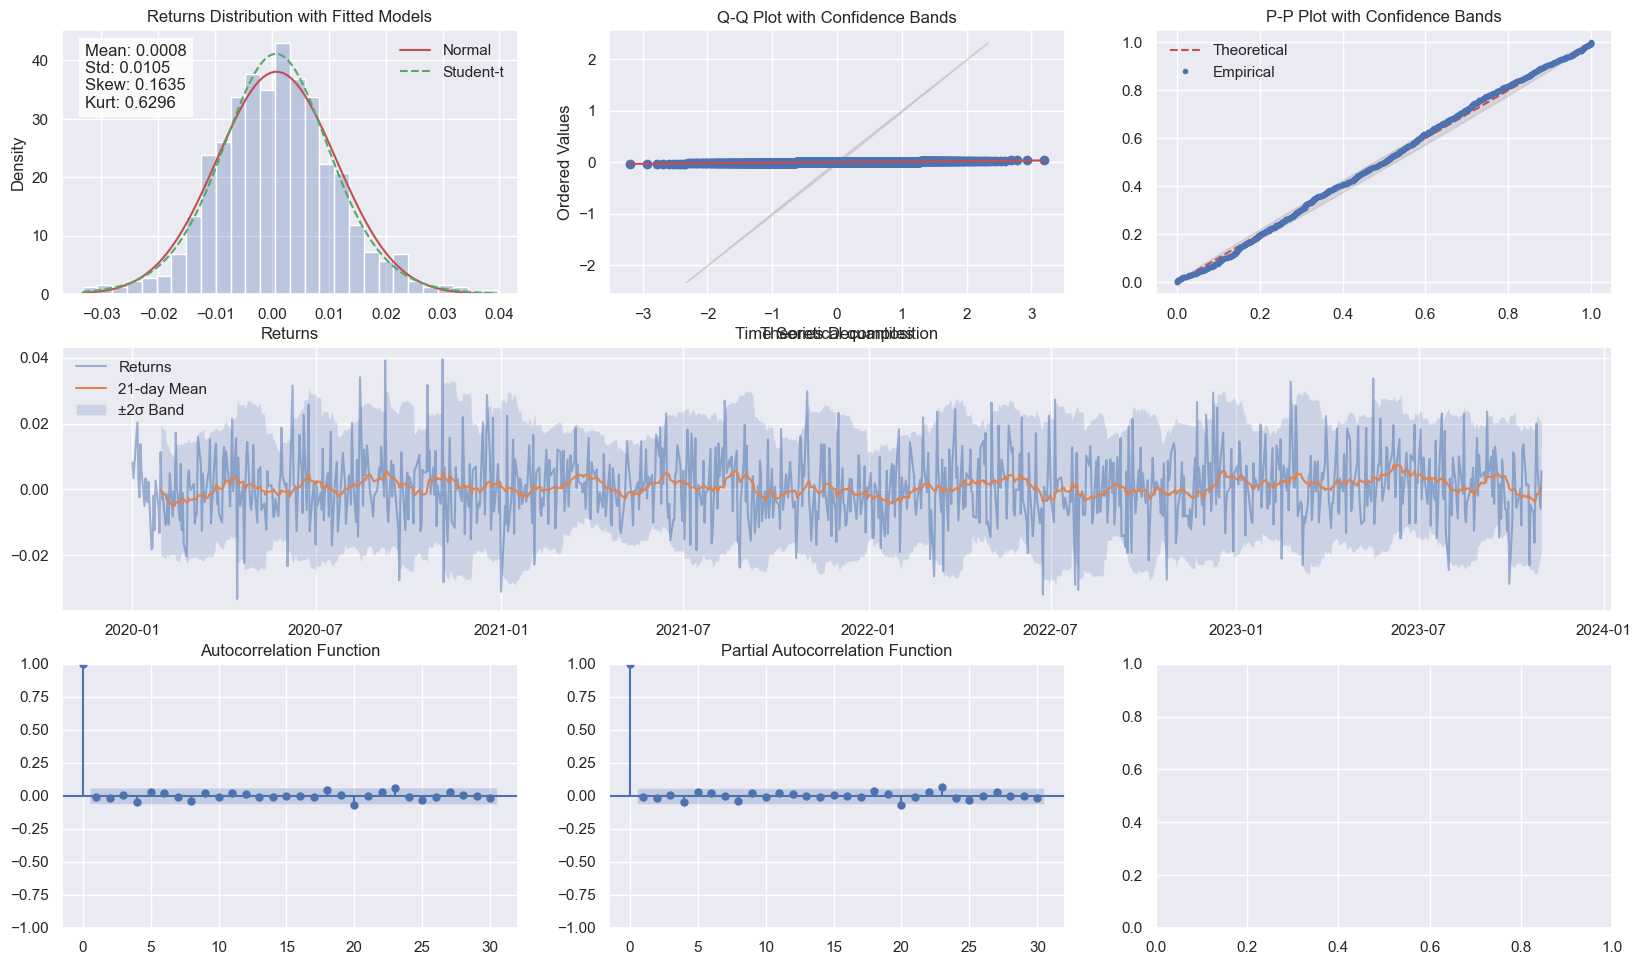

In [4]:

analyzer = StatisticalAnalyzer()

# Create comprehensive dashboard
dashboard = analyzer.create_statistical_dashboard()
plt.show()

# Generate statistical report
report = analyzer.generate_statistical_report()
print("\nStatistical Analysis Report:")
print(report)